Training samples available: 8592
Test class counts: (array([0, 1]), array([1083,    6]))

-------- Running Logistic Regression --------
               precision    recall  f1-score   support

Non-Habitable       1.00      0.98      0.99      1083
    Habitable       0.18      0.67      0.29         6

     accuracy                           0.98      1089
    macro avg       0.59      0.83      0.64      1089
 weighted avg       0.99      0.98      0.99      1089



<Figure size 1000x700 with 0 Axes>

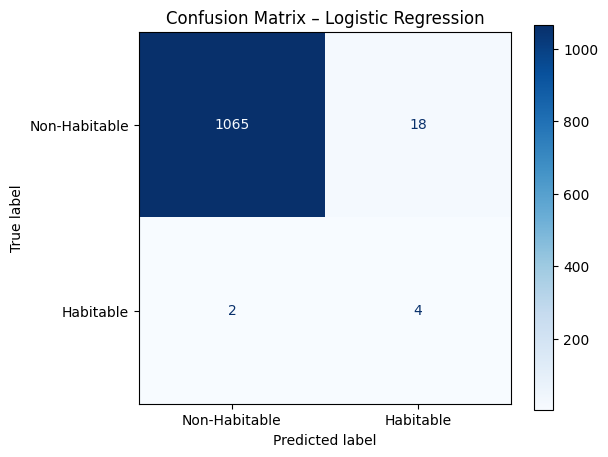


-------- Running Decision Tree (Depth=3) --------
               precision    recall  f1-score   support

Non-Habitable       1.00      0.99      0.99      1083
    Habitable       0.20      0.50      0.29         6

     accuracy                           0.99      1089
    macro avg       0.60      0.74      0.64      1089
 weighted avg       0.99      0.99      0.99      1089



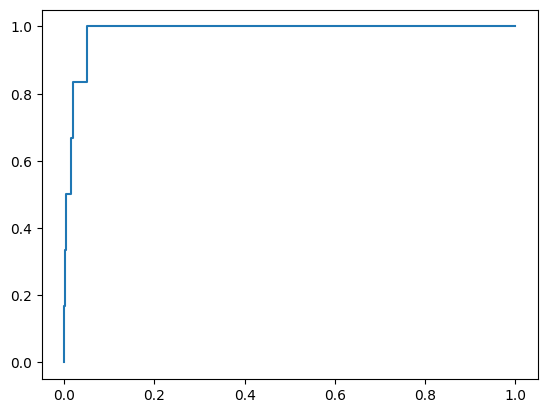

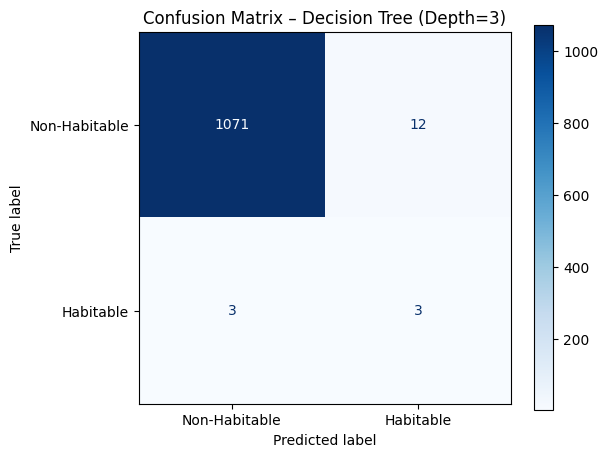

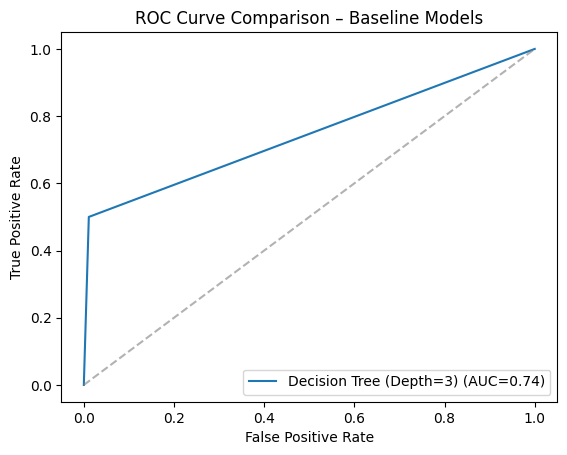


BASELINE MODEL PERFORMANCE SUMMARY
                  Model  Accuracy  Precision   Recall       F1       F2
    Logistic Regression  0.981635   0.181818 0.666667 0.285714 0.434783
Decision Tree (Depth=3)  0.986226   0.200000 0.500000 0.285714 0.384615


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# =====================================================
# STEP 1: READ CLEAN DATASETS
# =====================================================
X_tr = pd.read_csv("X_train_final.csv")
y_tr = pd.read_csv("y_train_final.csv").squeeze()

X_te = pd.read_csv("X_test_final.csv")
y_te_raw = pd.read_csv("y_test_final.csv").squeeze()

# Convert regression target into binary class (same threshold as preprocessing)
y_te = (y_te_raw > 0.7).astype(int)

print("Training samples available:", X_tr.shape[0])
print("Test class counts:", np.unique(y_te, return_counts=True))

# =====================================================
# STEP 2: DEFINE MODELS (BASELINES)
# =====================================================
def build_model(model_type):
    if model_type == "logistic":
        return Pipeline([
            ("norm", StandardScaler()),
            ("model", LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                random_state=42
            ))
        ])
    elif model_type == "tree":
        return Pipeline([
            ("norm", StandardScaler()),
            ("model", DecisionTreeClassifier(
                max_depth=3,
                class_weight="balanced",
                random_state=42
            ))
        ])

models = {
    "Logistic Regression": build_model("logistic"),
    "Decision Tree (Depth=3)": build_model("tree")
}

# =====================================================
# STEP 3: TRAINING + EVALUATION LOOP
# =====================================================
summary_rows = []
plt.figure(figsize=(10, 7))

for label, model in models.items():
    print(f"\n{'-'*8} Running {label} {'-'*8}")

    # Fit model
    model.fit(X_tr, y_tr)

    # Predictions
    y_hat = model.predict(X_te)
    y_score = model.predict_proba(X_te)[:, 1]

    # Metrics (recall-heavy evaluation)
    acc = accuracy_score(y_te, y_hat)
    prec = precision_score(y_te, y_hat, zero_division=0)
    rec = recall_score(y_te, y_hat)
    f1 = f1_score(y_te, y_hat, zero_division=0)
    f2 = fbeta_score(y_te, y_hat, beta=2, zero_division=0)

    summary_rows.append({
        "Model": label,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "F2": f2
    })

    # Text report
    print(classification_report(
        y_te,
        y_hat,
        target_names=["Non-Habitable", "Habitable"]
    ))

    # Confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_te,
        y_hat,
        display_labels=["Non-Habitable", "Habitable"],
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"Confusion Matrix – {label}")
    plt.grid(False)
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")

# =====================================================
# STEP 4: FINAL ROC VISUAL
# =====================================================
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison – Baseline Models")
plt.legend(loc="lower right")
plt.show()

# =====================================================
# STEP 5: BASELINE PERFORMANCE TABLE
# =====================================================
results_df = pd.DataFrame(summary_rows)
print("\n" + "="*45)
print("BASELINE MODEL PERFORMANCE SUMMARY")
print("="*45)
print(results_df.sort_values("F2", ascending=False).to_string(index=False))
